<a href="https://colab.research.google.com/github/XuanLoc2578/NLP_Basic/blob/main/Torch_NameGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from io import open
import glob
import os
import string
import unicodedata

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time

In [ ]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1

In [ ]:
files = glob.glob('/content/sample_data/*.txt')

In [ ]:
def unicode2Ascii(s):
  return ''.join(
      c for c in unicodedata.normalize("NFD", s)
      if unicodedata.category(c) != "Mn"
      and c in all_letters
  )

In [ ]:
def readLines(filename):
  with open(filename, encoding="UTF-8") as some_file:
    return [unicode2Ascii(line.strip()) for line in some_file]

In [ ]:
categories_line = {}
all_categories = []

for filename in files:
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readLines(filename)
  categories_line[category] = lines

n_categories = len(all_categories)

In [ ]:
unicode2Ascii("O'Neil")

"O'Neil"

In [ ]:
class RNN(nn.Module):
  def __init__(self, inp_size, hid_size, outp_size):
    super().__init__()
    self.hid_size = hid_size

    self.i2o = nn.Linear(inp_size + hid_size + n_categories, outp_size)
    self.i2h = nn.Linear(inp_size + hid_size + n_categories, hid_size)
    self.o2o = nn.Linear(outp_size + hid_size, outp_size)

    self.dropout = nn.Dropout(0.1)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, category, inp, hid):
    inp_combined = torch.cat((category, inp, hid), 1)
    hidden = self.i2h(inp_combined)
    output = self.i2o(inp_combined)
    outp_combined = torch.cat((output, hid), 1)
    output = self.o2o(outp_combined)
    output = self.dropout(output)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hid_size)

In [ ]:
inp_size = outp_size = n_letters
hid_size = 128

model = RNN(inp_size, hid_size, outp_size)

In [ ]:
def randomChoice(l):
  return l[random.randint(0, len(l)-1)]

def randomTrainingPair():
  category = randomChoice(all_categories)
  line = randomChoice(categories_line[category])
  return category, line

In [ ]:
# One-hot vector for category
def categoryTensor(category):
  li = all_categories.index(category)
  tensor = torch.zeros(1, n_categories)
  tensor[0][li] = 1
  return tensor

In [ ]:
# One-hot matrix for the 1st to the last letter not including <EOS>
def inputTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li in range(len(line)):
    letter = line[li]
    tensor[li][0][all_letters.find(letter)] = 1
  return tensor

In [ ]:
# LongTensor for sencond to end letter including <EOS> for target
def targetTensor(line):
  letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
  letter_indexes.append(n_letters - 1) # != <EOS>
  return torch.LongTensor(letter_indexes)

In [ ]:
def randomTrainingSample():
  category, line = randomTrainingPair()
  category_tensor = categoryTensor(category)
  input_line_tensor = inputTensor(line)
  target_line_tensor = targetTensor(line)
  return category_tensor, input_line_tensor, target_line_tensor 

In [ ]:
lr = 0.0005
criterian = nn.NLLLoss()
solver = optim.Adam(model.parameters(), lr=lr)

In [ ]:
def train(category_tensor, input_line_tensor, target_line_tensor):
  target_line_tensor.unsqueeze_(-1)
  hidden = model.initHidden()

  model.zero_grad()

  loss = 0

  for i in range(input_line_tensor.size(0)):
    output, hidden = model(category_tensor, input_line_tensor[i], hidden)
    l = criterian(output, target_line_tensor[i])
    loss += l

  loss.backward()

  solver.step()

  return output, loss.item() / input_line_tensor.size(0)  

In [ ]:
def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' %(m, s)

In [ ]:
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters+1):
  output, loss = train(*randomTrainingSample())
  total_loss += loss

  if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

  if iter % plot_every == 0:
      all_losses.append(total_loss / plot_every)
      total_loss = 0

0m 23s (5000 5%) 2.7676
0m 38s (10000 10%) 1.9183
0m 54s (15000 15%) 2.4401
1m 10s (20000 20%) 1.9279
1m 25s (25000 25%) 2.0977
1m 41s (30000 30%) 1.7497
1m 58s (35000 35%) 2.1403
2m 13s (40000 40%) 2.0328
2m 28s (45000 45%) 2.8834
2m 43s (50000 50%) 2.1499
2m 58s (55000 55%) 1.3262
3m 13s (60000 60%) 1.7301
3m 28s (65000 65%) 1.5467
3m 43s (70000 70%) 2.2299
3m 59s (75000 75%) 1.6108
4m 14s (80000 80%) 2.1116
4m 32s (85000 85%) 2.0927
4m 48s (90000 90%) 2.4036
5m 4s (95000 95%) 1.2351
5m 20s (100000 100%) 2.5082


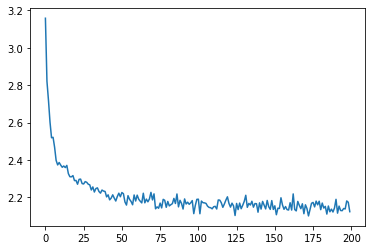

In [ ]:
plt.figure()
plt.plot(all_losses)

In [ ]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = model.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = model(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

In [ ]:
# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [ ]:
samples('Italian', 'NXL')
samples('Portuguese', 'NXL')

Nastimbi
Xuris
Laca
Nasello
Xider
Lachaloo
